In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time
import matplotlib.pyplot as plt  
import seaborn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score,cross_val_predict
%matplotlib inline
import statsmodels.api as sm

In [2]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
from sklearn.pipeline import Pipeline

In [3]:
x_value = pd.read_excel('BearBuy Variables.xlsx',encoding = 'cp437', sheet_name = "Sheet1", thousands = ",")
y_value = pd.read_excel('TimeInQueue_withBusinessHrs.xlsx',encoding = 'cp437', sheet_name = "Sheet1")

In [4]:
print(x_value.shape)
print(y_value.shape)

(43674, 21)
(408, 11)


In [5]:
#Inner joining the x and y variables together
#Each unique requisition that is completed and went through SCM (y_value) has line specific information (x_value)
Variables = pd.merge(y_value, x_value, how='inner', on='PR ID', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
Variables.shape

(602, 31)

In [6]:
#####################################################################
#Transform Data 
#####################################################################

In [7]:
#Classify departments as a high purchaser or not
DeptPurchaseFreq = Variables['Home Department'].value_counts().reset_index(name="count_dept")
DeptPurchaseFreq = pd.DataFrame(DeptPurchaseFreq)

#Find the 75% quartile
quantile_dept = DeptPurchaseFreq.loc[:,"count_dept"].quantile(q=0.75)
print("The quantile is", quantile_dept)

DeptPurchaseFreq["High Purchaser?"] = np.nan
DeptPurchaseFreq["High Purchaser?"] = (DeptPurchaseFreq['count_dept'] > quantile_dept)
#DeptPurchaseFreq
Variables = pd.merge(Variables, DeptPurchaseFreq, how='inner', on=None, left_on="Home Department", right_on="index",
        left_index=False, right_index=False, sort=True,
        suffixes=('_x', '_y'), copy=True, indicator=False,
        validate=None)
#Variables

The quantile is 5.0


In [8]:
#Classify suppliers as a frequently used vendor or not
SupplierFreq = Variables['Supplier Name'].value_counts().reset_index(name="count_supplier")
SupplierFreq = pd.DataFrame(SupplierFreq)

#Find the 75% quartile
quantile_supplier = SupplierFreq.loc[:,"count_supplier"].quantile(q=0.75)
print("The quantile is", quantile_supplier)

SupplierFreq["HighSupplierFreq"] = np.nan
SupplierFreq["HighSupplierFreq"] = (SupplierFreq['count_supplier'] > quantile_supplier)
#SupplierFreq
Variables = pd.merge(Variables, SupplierFreq, how='inner', on=None, left_on="Supplier Name", right_on="index",
        left_index=False, right_index=False, sort=True,
        suffixes=('_x', '_y'), copy=True, indicator=False,
        validate=None)
#Variables

The quantile is 2.0


In [9]:
#Classify the PO totals as low, mid, or high.
#Low is less than 25,000, mid is between 25,000 and 100,000, and high is over 100,000.
Variables["PO Total_Class"] = np.nan
Variables["PO Total_Class"] = Variables['PO Total'].apply(lambda x:"low" if x<25000 else ("med" if x<100000 else "high"))
#Variables

In [10]:
#Classify the Time in Queue as "Easy" or "Hard"
#Easy is requisition times less than the median value of Time in Queue, while Hard is more than the median.

#Find the median
Unique_Time = Variables[["PR ID","Time In Queue"]]
Unique_Time = Unique_Time.drop_duplicates(subset=["PR ID"])
median = Unique_Time["Time In Queue"].median()
print("The median is", median)

#Set conditions for classification
Variables["REQ Difficulty LV"] = np.nan
Variables["REQ Difficulty LV"] = Variables['Time In Queue'].apply(lambda x:"easy" if x< median else "hard")
#Variables

The median is 880.0


In [11]:
#Per Melissa, determined if a commodity code is a service, good, or both.
#Create a list for which are services and both
ServiceCode = [5,55,85,93,120,134,150,170,188,198,205,208,265,298,325,326,327,328,329,331,332]
BothCode = [227,307,333]

#Function to compare x to above lists of values
def extractProductType(x):
    if x in ServiceCode:
        return "service"
    elif x in BothCode:
        return "both"
    else:
        return 'good'

#Set conditions for classification    
Variables["Product Type"] = np.nan
Variables["Product Type"] = Variables['Commodity Code'].apply(lambda x : extractProductType(x))
#Variables

In [12]:
#Classify function type as either research or not
ResearchFunctionValue = [44, 45, 79]
def extractProductType(x):
       if x in ResearchFunctionValue:
           return "Research Fund"
       else:
           return 'Not Research Fund'
Variables["Research_Fund?"] = Variables['Function Value']
Variables["Research_Fund?"] = Variables['Function Value'].apply(lambda x : extractProductType(x))
ResFund_df = Variables[["Function Value", 'Research_Fund?']]
#ResFund_df['Research_Fund?'].value_counts()

In [13]:
#Classify fund type as either federal or not
FederalFundValue = [4000, 4001, 4002, 4003, 4004, 4005, 4006, 6030, 9250, 9251]
def extractProductType(x):
       if x in FederalFundValue:
           return "Federal Fund"
       else:
           return 'Not Federal Fund'
Variables["Federal_Fund?"] = Variables['Fund Value']
Variables["Federal_Fund?"] = Variables['Fund Value'].apply(lambda x : extractProductType(x))
FedFund_df = Variables[["Fund Value", 'Federal_Fund?']]
#FedFund_df['Federal_Fund?'].value_counts()

In [14]:
#Fill nulls in respective columns
values = {'Supplier Class': "Non-Disadvantaged", 'HIPAA': 'Not_Hippa'}
Variables = Variables.fillna(value=values)
#Variables.isnull().any()

In [15]:
#Check for multicolinearity
#Variables.corr()

In [16]:
#Create dummy variables for categorical values
dummy_purchaser = pd.get_dummies(Variables["High Purchaser?"], prefix='High Purchaser')
dummy_PO_Total_Class = pd.get_dummies(Variables["PO Total_Class"], prefix='PO_Total_Class')
dummy_User = pd.get_dummies(Variables["User"], prefix='User')
dummy_Item_Type = pd.get_dummies(Variables["Item Type"], prefix='Item Type')
dummy_Form_Type = pd.get_dummies(Variables["Form Type"], prefix='Form Type')
dummy_DiffLV = pd.get_dummies(Variables["REQ Difficulty LV"], prefix='DiffLV')
dummy_Product_Type = pd.get_dummies(Variables["Product Type"], prefix='PType')
dummy_supplier = pd.get_dummies(Variables["HighSupplierFreq"], prefix='Frequent Supplier')
dummy_fed_fund = pd.get_dummies(Variables["Federal_Fund?"], prefix='Federal Fund')
dummy_research_fund = pd.get_dummies(Variables["Research_Fund?"], prefix='Research Fund')
dummy_hipaa = pd.get_dummies(Variables["HIPAA"], prefix='hipaa')
dummy_supplier_class = pd.get_dummies(Variables["Supplier Class"], prefix='SupplierClass')

#Create a dummy list
frames = [dummy_purchaser, dummy_PO_Total_Class, dummy_User, dummy_Item_Type, 
          dummy_Form_Type, dummy_DiffLV,dummy_Product_Type,dummy_supplier,
          dummy_fed_fund, dummy_research_fund, dummy_hipaa,dummy_supplier_class
         ]

#Joining the original dataframe to the dummy list
result = Variables.join(frames)
result = result.drop(columns=['Unnamed: 0_x','Unnamed: 0_y','index_x','index_y','Fund','Function'])
result.columns
#result.to_excel("result.xlsx")

Index(['PR ID', 'User', 'Time In Queue', 'End Time', 'DeptCode Approval Time',
       'Adhoc1 Approval Time', 'Adhoc2 Approval Time',
       'Associate Buyer Approval Time', 'Advance Payment Approval Time',
       'PR Validation1 Approval Time', 'Item Type', 'Form Type', 'FormId',
       'Commodity Code', 'Unit Price', 'Extended Price', 'Home Department',
       'PR Line #_actual', 'Line Status', 'Product Description',
       'Supplier Name', 'PR Line #_max', 'PO Total', 'HIPAA', 'Function Value',
       'Fund Value', 'Supplier Class', 'count_dept', 'High Purchaser?',
       'count_supplier', 'HighSupplierFreq', 'PO Total_Class',
       'REQ Difficulty LV', 'Product Type', 'Research_Fund?', 'Federal_Fund?',
       'High Purchaser_False', 'High Purchaser_True', 'PO_Total_Class_high',
       'PO_Total_Class_low', 'PO_Total_Class_med', 'User_Byron Wilson',
       'User_Christina Morache', 'User_Daisy Palma', 'User_Jenny Sangpolsit',
       'User_Jose Padilla', 'User_Josie Ip', 'User_Laris

In [17]:
###########################################################################
#MODELS
###########################################################################

#Set the random_state
seed=1

In [18]:
#####################################################################################
#Fitting the model to a multiple linear regression
#####################################################################################

In [19]:
#Declare x and y values
X = result[['PR Line #_max', 
                'PO_Total_Class_high',
                'PO_Total_Class_low',
                'User_Byron Wilson', 
                'User_Christina Morache', 
                'User_Daisy Palma', 
                'User_Jose Padilla', 
                'User_Josie Ip',
                'User_Robert Puerzer',
                'User_Rosemarie Hughes', 
                'User_Tanya Krupsky', 
                'User_Tyrone Webb',
                'User_Yvette Villa-Carlos',
                'Form Type_Non Catalog',
                'Form Type_Professional Services/Independent Consulting',
                'Frequent Supplier_True'
               ]].values
y = result[['Time In Queue']].values

#Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [20]:
#Insignificant and dropped from total 45 variables for predicting Time in Queue
    #1. 'Item Type_Punch-out Product'
    #2. 'SupplierClass_Veteran Owned Small Business'
    #3. 'PR Line #_actual'
    #4. 'Form Type_Amount-based PO'
    #5. 'User_Laura Morsony'
    #6. 'Form Type_Software and Cloud Computing'
    #7. 'Item Type_SQ Hosted Product'
    #8. 'Form Type_Facility Rental'
    #9. 'Unit Price'
    #10.'Extended Price'
    #11.'Form Type_Payment Request'
    #12.'Research Fund_Not Research Fund'
    #13.'Form Type_Catalog'
    #14.'PType_good'
    #15.'Form Type_Equipment Lease/Loan/Purchase'
    #16.'Form Type_~PDPR~NoPO~SBUY_ChangeOrder'
    #17.'PType_both'
    #18.'Federal Fund_Not Federal Fund'
    #19.'SupplierClass_Minority Business Enterprise'
    #20.'SupplierClass_Women Business Enterprise'
    #21.'SupplierClass_Disadvantaged Business Enterprise'
    #22.'SupplierClass_Small Disadvantaged Business'
    #23.'hipaa_Not_Hippa'
    #24.'SupplierClass_Small Business'
    #25.'User_Larissa Garcia'
    #26.'High Purchaser_True'
    #27.'SupplierClass_Not Open for Ordering'
    #28.'Form Type_Meeting and Entertainment Payment Request'
    #29.'SupplierClass_Non-Disadvantaged'   

In [21]:
#Use the sm.OLS function to determine significant variables
X_trainOLS = sm.add_constant(X_train)
model = sm.OLS(y_train, X_trainOLS).fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     26.73
Date:                Mon, 30 Sep 2019   Prob (F-statistic):           7.42e-56
Time:                        16:23:29   Log-Likelihood:                -4069.5
No. Observations:                 481   AIC:                             8173.
Df Residuals:                     464   BIC:                             8244.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4681.8759    692.979      6.756      0.000    3320.110    6043.642
x1            87.5341     19.536      4.481      0.000      49.145     125.923
x2          -917.5698    280.872     -3.267      0.001   -1469.509    -365.631
x3          -848.4563    146.101     -5.807      0.000   -1135.558    -561.354
x4         -3183.5347    687.092     -4.633      0.000   -4533.732   -1833.337
x5         -3783.7801    692.424     -5.465      0.000   -5144.456   -2423.104
x6         -2641.5710    708.258     -3.730      0.000   -4033.361   -1249.780
x7         -2268.1889    715.875     -3.168      0.002   -3674.948    -861.430
x8         -1473.2150    699.994     -2.105      0.036   -2848.766     -97.664
x9         -3071.4602    695.168     -4.418      0.000   -4437.527   -1705.393
x10        -3765.5315    685.986     -5.489      0.000   -5113.555   -2417.508
x11        -2573.6718    696.449     -3.695      0.000   -3942.257   -1205.087
x12        -1410.7493    691.883     -2.039      0.042   -2770.361     -51.138
x13        -2687.8577    751.942     -3.575      0.000   -4165.490   -1210.225
x14          517.3361    141.400      3.659      0.000     239.473     795.199
x15         1661.3887    286.297      5.803      0.000    1098.790    2223.988
x16         -497.4307    130.163     -3.822      0.000    -753.212    -241.649
==============================================================================
Omnibus:                      219.872   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1614.394
Skew:                           1.832   Prob(JB):                         0.00
Kurtosis:                      11.193   Cond. No.                         198.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#Find the highest p-value
model.pvalues.sort()
print(model.pvalues[-2],model.pvalues[-1])

0.035862390596288804 0.04201609059657115


In [23]:
#Train the model using the training data
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
#Create a list of predicted values using the above model
y_pred = regressor.predict(X_test)

In [25]:
#The linear regression equation
print("Intercept:",regressor.intercept_)
print("Coefficients:",regressor.coef_)

Intercept: [4681.8759117]
Coefficients: [[   87.53412741  -917.5697598   -848.4562543  -3183.53472769
  -3783.78005413 -2641.57097294 -2268.18894217 -1473.21496845
  -3071.46021161 -3765.53153029 -2573.67176619 -1410.74932905
  -2687.85766931   517.33608671  1661.3887409   -497.43067722]]


In [26]:
#Calculate error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 974.6757249882091
Mean Squared Error: 2168955.3592926115
Root Mean Squared Error: 1472.7373694221965


In [27]:
#####################################################################################
#Fitting the model to a logistic regression
#####################################################################################

In [28]:
#Declare x and y values for the logistic models
Xlog = result[['PR Line #_max', 
                'High Purchaser_True',
                'PO_Total_Class_high',
                'PO_Total_Class_low',
                'User_Byron Wilson', 
                'User_Christina Morache', 
                'User_Daisy Palma',
                'User_Josie Ip',
                'User_Robert Puerzer', 
                'User_Rosemarie Hughes', 
                'User_Tanya Krupsky',
                'Item Type_Punch-out Product',
                'Form Type_Amount-based PO', 
                'Form Type_Professional Services/Independent Consulting', 
                'PType_both',
                'Frequent Supplier_True',
                'Research Fund_Research Fund',
                'SupplierClass_Small Business'
               ]].values
ylog = result[['DiffLV_hard']].values

#Create test and train datasets
Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(Xlog, ylog, test_size=0.2, random_state=seed)

In [29]:
#Insignificant and dropped from total 45 variables for predicting Difficulty level Hard
    #1. 'Extended Price'
    #2. 'User_Laura Morsony' --> gets added to bucket with Jenny Sangpolsit
    #3. 'Form Type_~PDPR~NoPO~SBUY_ChangeOrder'--> Gets added with after the fact
    #4. 'PR Line #_actual'
    #5. 'Supplier Class_Women Business Enterprise'
    #6. 'User_Larissa Garcia' --> gets added with Jenny Sangpolsit
    #7. 'Federal Fund_Not Federal Fund' -->Gets added to federal fund
    #8. 'Unit Price'
    #9. 'Form Type_Equipment Lease/Loan/Purchase' --> Gets added to form after the fact
    #10. 'Form Type_Software and Cloud Computing', --> Gets added to form after the fact
    #11. 'HIPAA?_Not HIPAA', Gets added to Hipaa
    #12. 'Form Type_Facility Rental' --> Form after the fact
    #13. 'Supplier Class_Not Open for Ordering', --> Women owned small business and women owned business enterprise
    #14. 'Form Type_Meeting and Entertainment Payment Request' --> added with other form types
    #15. 'User_Tyrone Webb' --> added with Jenny Sangpolsit
    #16. 'User_Jose Padilla' --> Gets added to Jenny Sangpolsit
    #17. 'Form Type_Non Catalog' --> gets added
    #18. 'Supplier Class_Veteran Owned Small Business' --> Gets added with other Supplier Class
    #19. 'Form Type_Catalog' --> Gets added to other forms
    #20. 'Item Type_SQ Hosted Product' --> Gets added to the other item type
    #21. 'Supplier Class_Small Disadvantaged Business', --> gets added to the other Supplier class
    #22. 'Product Type_Good' --> Gets added to other product type
    #23. 'Supplier Class_Minority Business Enterprise' --> groups with other supplier classes
    #24. 'Form Type_Payment Request', --> Joins other form types
    #25.  'Supplier Class_Disadvantaged Business Enterprise', --> gets grouped with other supplier class
    #26.  'Supplier Class_Non-Disadvantaged'-->  gets grouped with other supplier class
    #27.  'User_Yvette Villa-Carlos' --> Gets added with Jenny Sangpolsit

In [30]:
#Train the model using the training data
lr = LogisticRegression(solver='lbfgs',random_state = seed)
lr.fit(Xlog_train, ylog_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
#Create a list of predicted values using the above model
ylog_pred = lr.predict(Xlog_test)
ylog_prob = lr.predict_proba(Xlog_test)

#confusion matrix
confusion_matrix(ylog_test, ylog_pred)

array([[43, 18],
       [11, 49]], dtype=int64)

In [32]:
#Create a dataframe to see why the model predicted incorrectly
X_df = pd.DataFrame({'PR Line #_max': Xlog_test[:, 0],
                     'High Purchaser_True': Xlog_test[:, 1],
                     'PO_Total_Class_high': Xlog_test[:, 2],
                     'PO_Total_Class_low': Xlog_test[:, 3],
                     'User_Byron Wilson': Xlog_test[:, 4],
                     'User_Christina Morache': Xlog_test[:, 5],
                     'User_Daisy Palma': Xlog_test[:, 6],
                     'User_Josie Ip': Xlog_test[:, 7],
                     'User_Robert Puerzer': Xlog_test[:, 8],
                     'User_Rosemarie Hughes': Xlog_test[:, 9],
                     'User_Tanya Krupsky': Xlog_test[:, 10],
                     'Item Type_Punch-out Product': Xlog_test[:, 11],
                     'Form Type_Amount-based PO': Xlog_test[:, 12],
                     'Form Type_Professional Services/Independent Consulting': Xlog_test[:, 13],
                     'PType_both': Xlog_test[:, 14],
                     'Frequent Supplier_True': Xlog_test[:, 15],
                     'Research Fund_Research Fund': Xlog_test[:, 16],
                     'SupplierClass_Small Business': Xlog_test[:, 17]})

ylog_df = pd.DataFrame({'ylog_test': ylog_test[:, 0], 'ylog_pred': ylog_pred, 'ylog_prob': ylog_prob[:, 0]})
#X_df.to_excel("x.xlsx")
#ylog_df.to_excel("y.xlsx")

In [33]:
#The logistic regression equation
print("Intercept:",lr.intercept_)
print("Coefficients:",lr.coef_)

Intercept: [2.14250688]
Coefficients: [[ 0.20363237  0.55581345 -0.78782183 -1.27365043 -0.8028768  -3.84951632
  -0.72535065 -0.21947711 -1.82571257 -3.97704178 -0.86188142  1.09387241
  -0.80654328  0.59904906 -0.69390379 -0.7488908  -0.15703007  0.41504296]]


In [34]:
#Calculate error
print('Mean Absolute Error:', metrics.mean_absolute_error(ylog_test, ylog_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(ylog_test, ylog_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ylog_test, ylog_pred)))

Mean Absolute Error: 23.330578512396695
Mean Squared Error: 0.2396694214876033
Root Mean Squared Error: 0.4895604370122276


In [35]:
#####################################################################################
#Fitting the model to a decision tree
#####################################################################################

In [36]:
#Declare x and y values for the decision tree
Xtree = Xlog
ytree = result[['DiffLV_hard']].values

#Create test and train datasets
Xtree_train, Xtree_test, ytree_train, ytree_test = train_test_split(Xtree, ytree, test_size=0.2, random_state=seed)

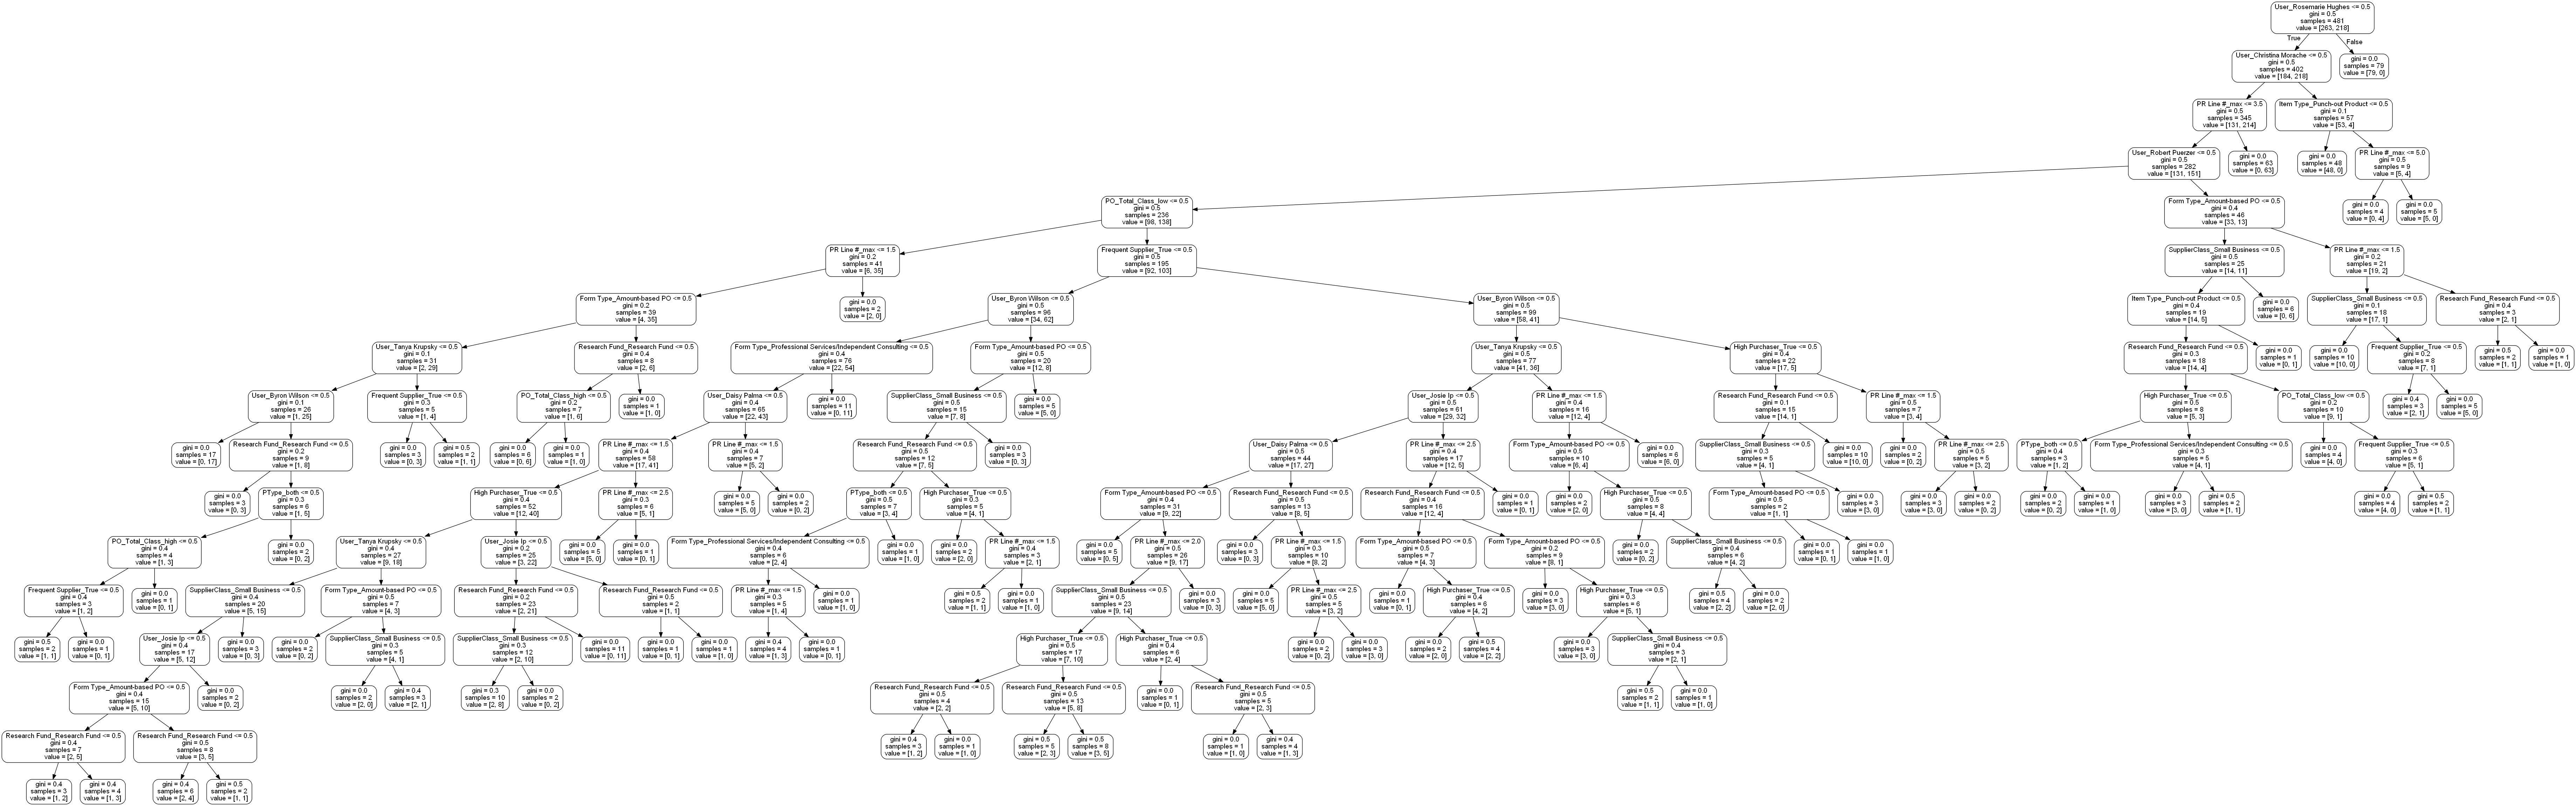

In [37]:
#Train the model using the training data
clf = tree.DecisionTreeClassifier(random_state=seed)
clf = clf.fit(Xtree_train, ytree_train)

#Plot the tree
export_graphviz(clf, out_file = 'clf.dot', feature_names=list(X_df), rounded = True, precision = 1)

#Save picture
(graph, ) = pydot.graph_from_dot_file(r'clf.dot')
graph.write_png('clf.png')
Image(filename='clf.png')

In [38]:
#Create a list of predicted values using the above model
ytree_pred = clf.predict(Xtree_test)

#confusion matrix
confusion_matrix(ytree_test, ytree_pred)

array([[49, 12],
       [12, 48]], dtype=int64)

In [39]:
#Calculate error
print('Mean Absolute Error:', metrics.mean_absolute_error(ytree_test, ytree_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(ytree_test, ytree_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytree_test, ytree_pred)))

Mean Absolute Error: 25.388429752066116
Mean Squared Error: 0.19834710743801653
Root Mean Squared Error: 0.4453617714151233


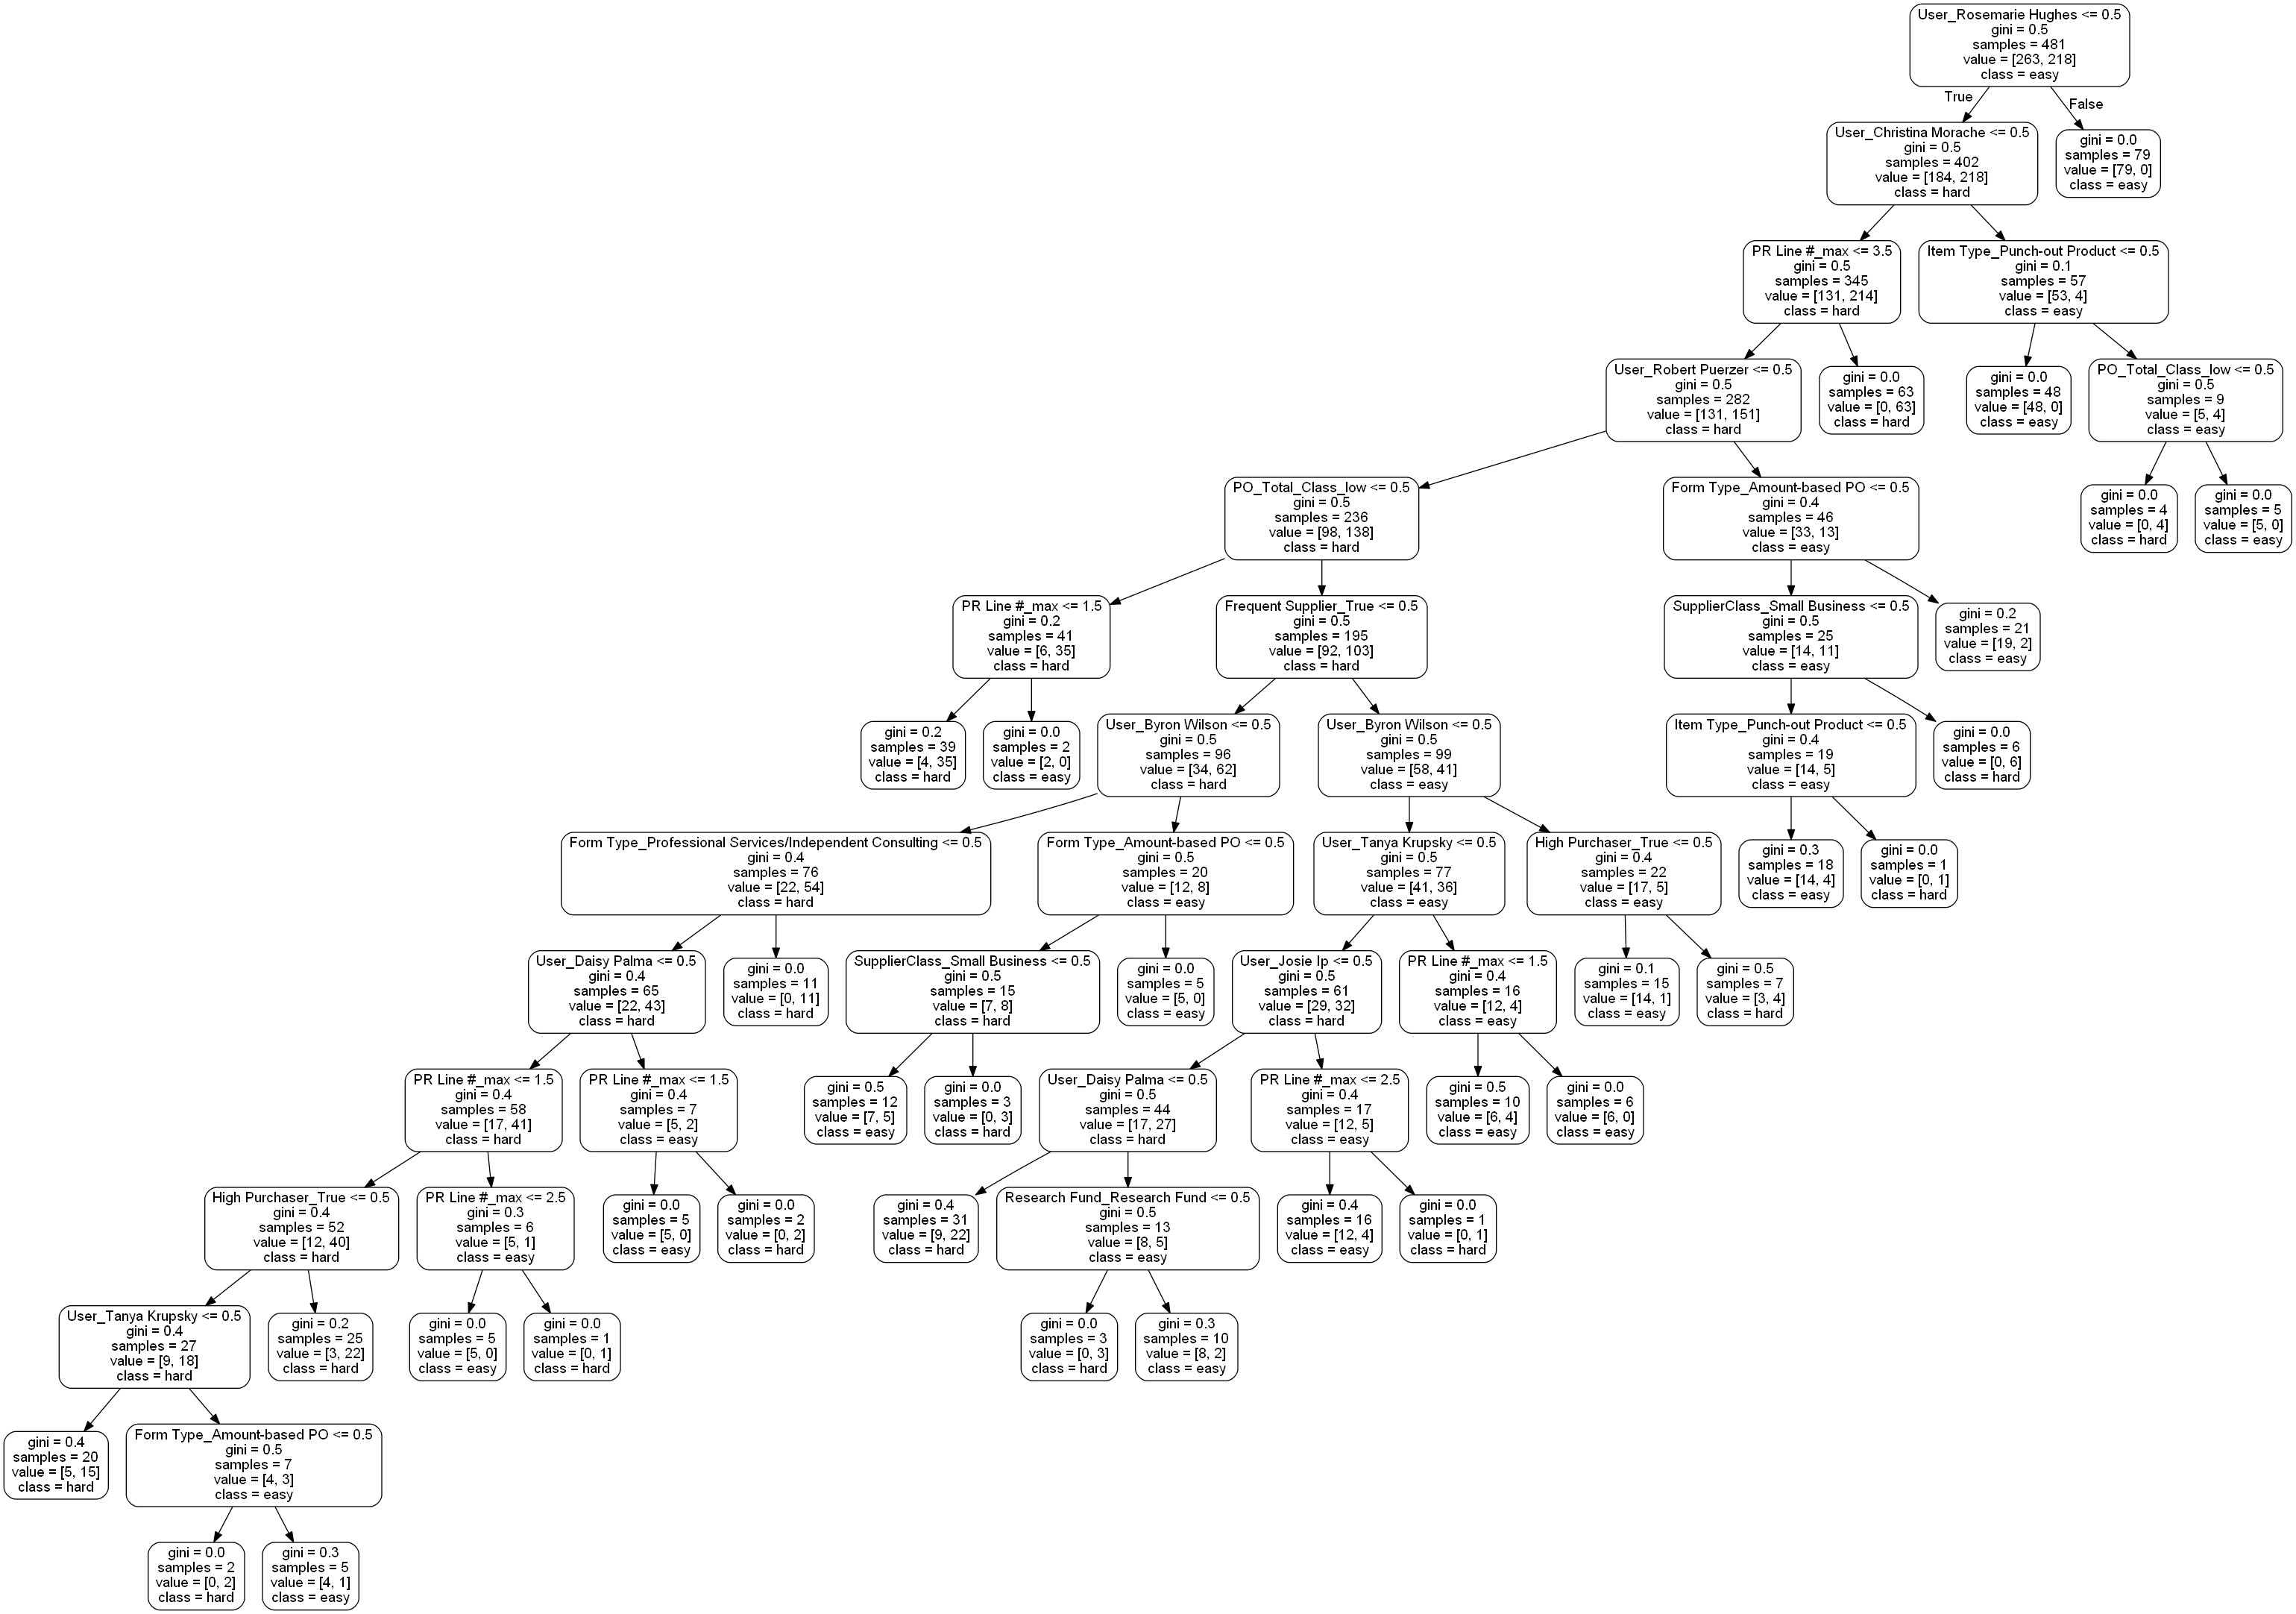

In [40]:
##################################################################
#Prune the decision tree
##################################################################

#Train the model using the training data
clf_pruned = tree.DecisionTreeClassifier(max_leaf_nodes=32, random_state = seed)

# Train Decision Tree Classifer
clf_pruned = clf_pruned.fit(Xtree_train, ytree_train)

#Predict the response for test dataset
y_predPrunedTree = clf_pruned.predict(Xtree_test)

#Plot the tree
output = ("easy","hard")
export_graphviz(clf_pruned, out_file = 'clf_pruned.dot',
                feature_names=list(X_df),
                class_names=list(output),
                rounded = True, precision = 1)

#Save picture
(graph, ) = pydot.graph_from_dot_file(r'clf_pruned.dot')
graph.write_png('clf_pruned.png')
Image(filename='clf_pruned.png')

In [41]:
#confusion matrix
confusion_matrix(ytree_test, y_predPrunedTree)

array([[50, 11],
       [ 9, 51]], dtype=int64)

In [42]:
#Calculate error
print('Mean Absolute Error of Pruned Tree:', metrics.mean_absolute_error( ytree_test, y_predPrunedTree))
print('Mean Squared Error of Pruned Tree:', metrics.mean_squared_error(ytree_test, y_predPrunedTree))
print('Root Mean Squared Error of Pruned Tree:', np.sqrt(metrics.mean_squared_error(ytree_test, y_predPrunedTree)))

Mean Absolute Error of Pruned Tree: 19.05785123966942
Mean Squared Error of Pruned Tree: 0.1652892561983471
Root Mean Squared Error of Pruned Tree: 0.4065578140908709


In [43]:
#for i in range(30, 40+1, 1):
#    clf_pruned = tree.DecisionTreeClassifier(max_leaf_nodes=i, random_state = seed)
#    clf_pruned = clf_pruned.fit(Xtree_train, ytree_train.ravel())
#    y_predPrunedTree = clf_pruned.predict(Xtree_test)
#    print('Mean Squared Error of Pruned Tree:', metrics.mean_squared_error(ytree_test, y_predPrunedTree))
#Mean Squared Error of Pruned Tree: 0.17355371900826447
#Mean Squared Error of Pruned Tree: 0.17355371900826447
#Mean Squared Error of Pruned Tree: 0.1652892561983471#####
#Mean Squared Error of Pruned Tree: 0.1652892561983471
#Mean Squared Error of Pruned Tree: 0.1652892561983471
#Mean Squared Error of Pruned Tree: 0.1652892561983471

In [44]:
#####################################################################################
#Fitting the model to Random Forest
#####################################################################################

In [45]:
#Declare x and y values for the random forest
Xrtree = result[['Unit Price',
                'Extended Price',
                'PR Line #_actual',
                'PR Line #_max', 
                'High Purchaser_True',
                'PO_Total_Class_high',
                'PO_Total_Class_low',
                'User_Byron Wilson', 
                'User_Christina Morache', 
                'User_Daisy Palma', 
                'User_Jose Padilla', 
                'User_Josie Ip',
                'User_Larissa Garcia', 
                'User_Laura Morsony', 
                'User_Robert Puerzer',
                'User_Rosemarie Hughes', 
                'User_Tanya Krupsky', 
                'User_Tyrone Webb',
                'User_Yvette Villa-Carlos',
                'Item Type_Punch-out Product', 
                'Item Type_SQ Hosted Product', 
                'Form Type_Amount-based PO',
                'Form Type_Catalog', 
                'Form Type_Equipment Lease/Loan/Purchase',
                'Form Type_Facility Rental',
                'Form Type_Meeting and Entertainment Payment Request',
                'Form Type_Non Catalog', 
                'Form Type_Payment Request',
                'Form Type_Professional Services/Independent Consulting',
                'Form Type_Software and Cloud Computing',
                'Form Type_~PDPR~NoPO~SBUY_ChangeOrder',
                'PType_both', 
                'PType_good',
                'Frequent Supplier_True',
                'Federal Fund_Not Federal Fund', 
                'Research Fund_Not Research Fund',
                'hipaa_Not_Hippa',
                'SupplierClass_Disadvantaged Business Enterprise',
                'SupplierClass_Minority Business Enterprise',
                'SupplierClass_Not Open for Ordering', 
                'SupplierClass_Non-Disadvantaged',
                'SupplierClass_Small Business',
                'SupplierClass_Small Disadvantaged Business',
                'SupplierClass_Veteran Owned Small Business',
                'SupplierClass_Women Business Enterprise'
               ]].values
yrtree = ytree

#Create test and train datasets
Xrtree_train, Xrtree_test, yrtree_train, yrtree_test = train_test_split(Xrtree, yrtree, test_size=0.2, random_state=seed)

In [46]:
allfeatures = ['Unit Price','Extended Price','PR Line #_actual','PR Line #_max', 'High Purchaser_True',
               'PO_Total_Class_high','PO_Total_Class_low','User_Byron Wilson','User_Christina Morache', 
               'User_Daisy Palma','User_Jose Padilla','User_Josie Ip','User_Larissa Garcia','User_Laura Morsony', 
               'User_Robert Puerzer','User_Rosemarie Hughes','User_Tanya Krupsky','User_Tyrone Webb',
               'User_Yvette Villa-Carlos','Item Type_Punch-out Product','Item Type_SQ Hosted Product', 
               'Form Type_Amount-based PO','Form Type_Catalog','Form Type_Equipment Lease/Loan/Purchase',
               'Form Type_Facility Rental','Form Type_Meeting and Entertainment Payment Request',
               'Form Type_Non Catalog','Form Type_Payment Request',
               'Form Type_Professional Services/Independent Consulting',
               'Form Type_Software and Cloud Computing','Form Type_~PDPR~NoPO~SBUY_ChangeOrder',
               'PType_both','PType_good','Frequent Supplier_True','Federal Fund_Not Federal Fund', 
               'Research Fund_Not Research Fund','hipaa_Not_Hippa','SupplierClass_Disadvantaged Business Enterprise',
               'SupplierClass_Minority Business Enterprise','SupplierClass_Not Open for Ordering', 
               'SupplierClass_Non-Disadvantaged','SupplierClass_Small Business',
               'SupplierClass_Small Disadvantaged Business','SupplierClass_Veteran Owned Small Business',
               'SupplierClass_Women Business Enterprise']

In [47]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000,max_features=31,max_leaf_nodes=32, random_state = seed)

# Train the model on training data
rf.fit(Xrtree_train, yrtree_train.ravel());

# Use the forest's predict method on the test data
y_predRTree = rf.predict(Xrtree_test)

# Calculate the absolute errors
errors = abs(y_predRTree - yrtree_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Mean Absolute Error:', metrics.mean_absolute_error( yrtree_test, y_predRTree))
print('Mean Squared Error:', metrics.mean_squared_error( yrtree_test, y_predRTree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yrtree_test, y_predRTree)))

Mean Absolute Error: 0.5 degrees.
Mean Absolute Error: 0.2663711397796477
Mean Squared Error: 0.13830893919199957
Root Mean Squared Error: 0.37189909813281286


In [48]:
#1. Find the range where the smallest MSE may fall for max leaf nodes. 
#for i in range(10, 50+1, 1) -->32 nodes

#1A. Find where the smallest MSE is for max features.
#for i in range(1, 45+1, 1) ---> 31 features
#Mean Squared Error: 0.13830893919199957

#for i in range(30, 45+1, 1):
#    rf = RandomForestRegressor(n_estimators = 1000,max_features=i,max_leaf_nodes=32, random_state = seed)
#    rf.fit(Xrtree_train, yrtree_train.ravel())
#    y_predRTree = rf.predict(Xrtree_test)
#    print('Mean Squared Error:', metrics.mean_squared_error(yrtree_test, y_predRTree))

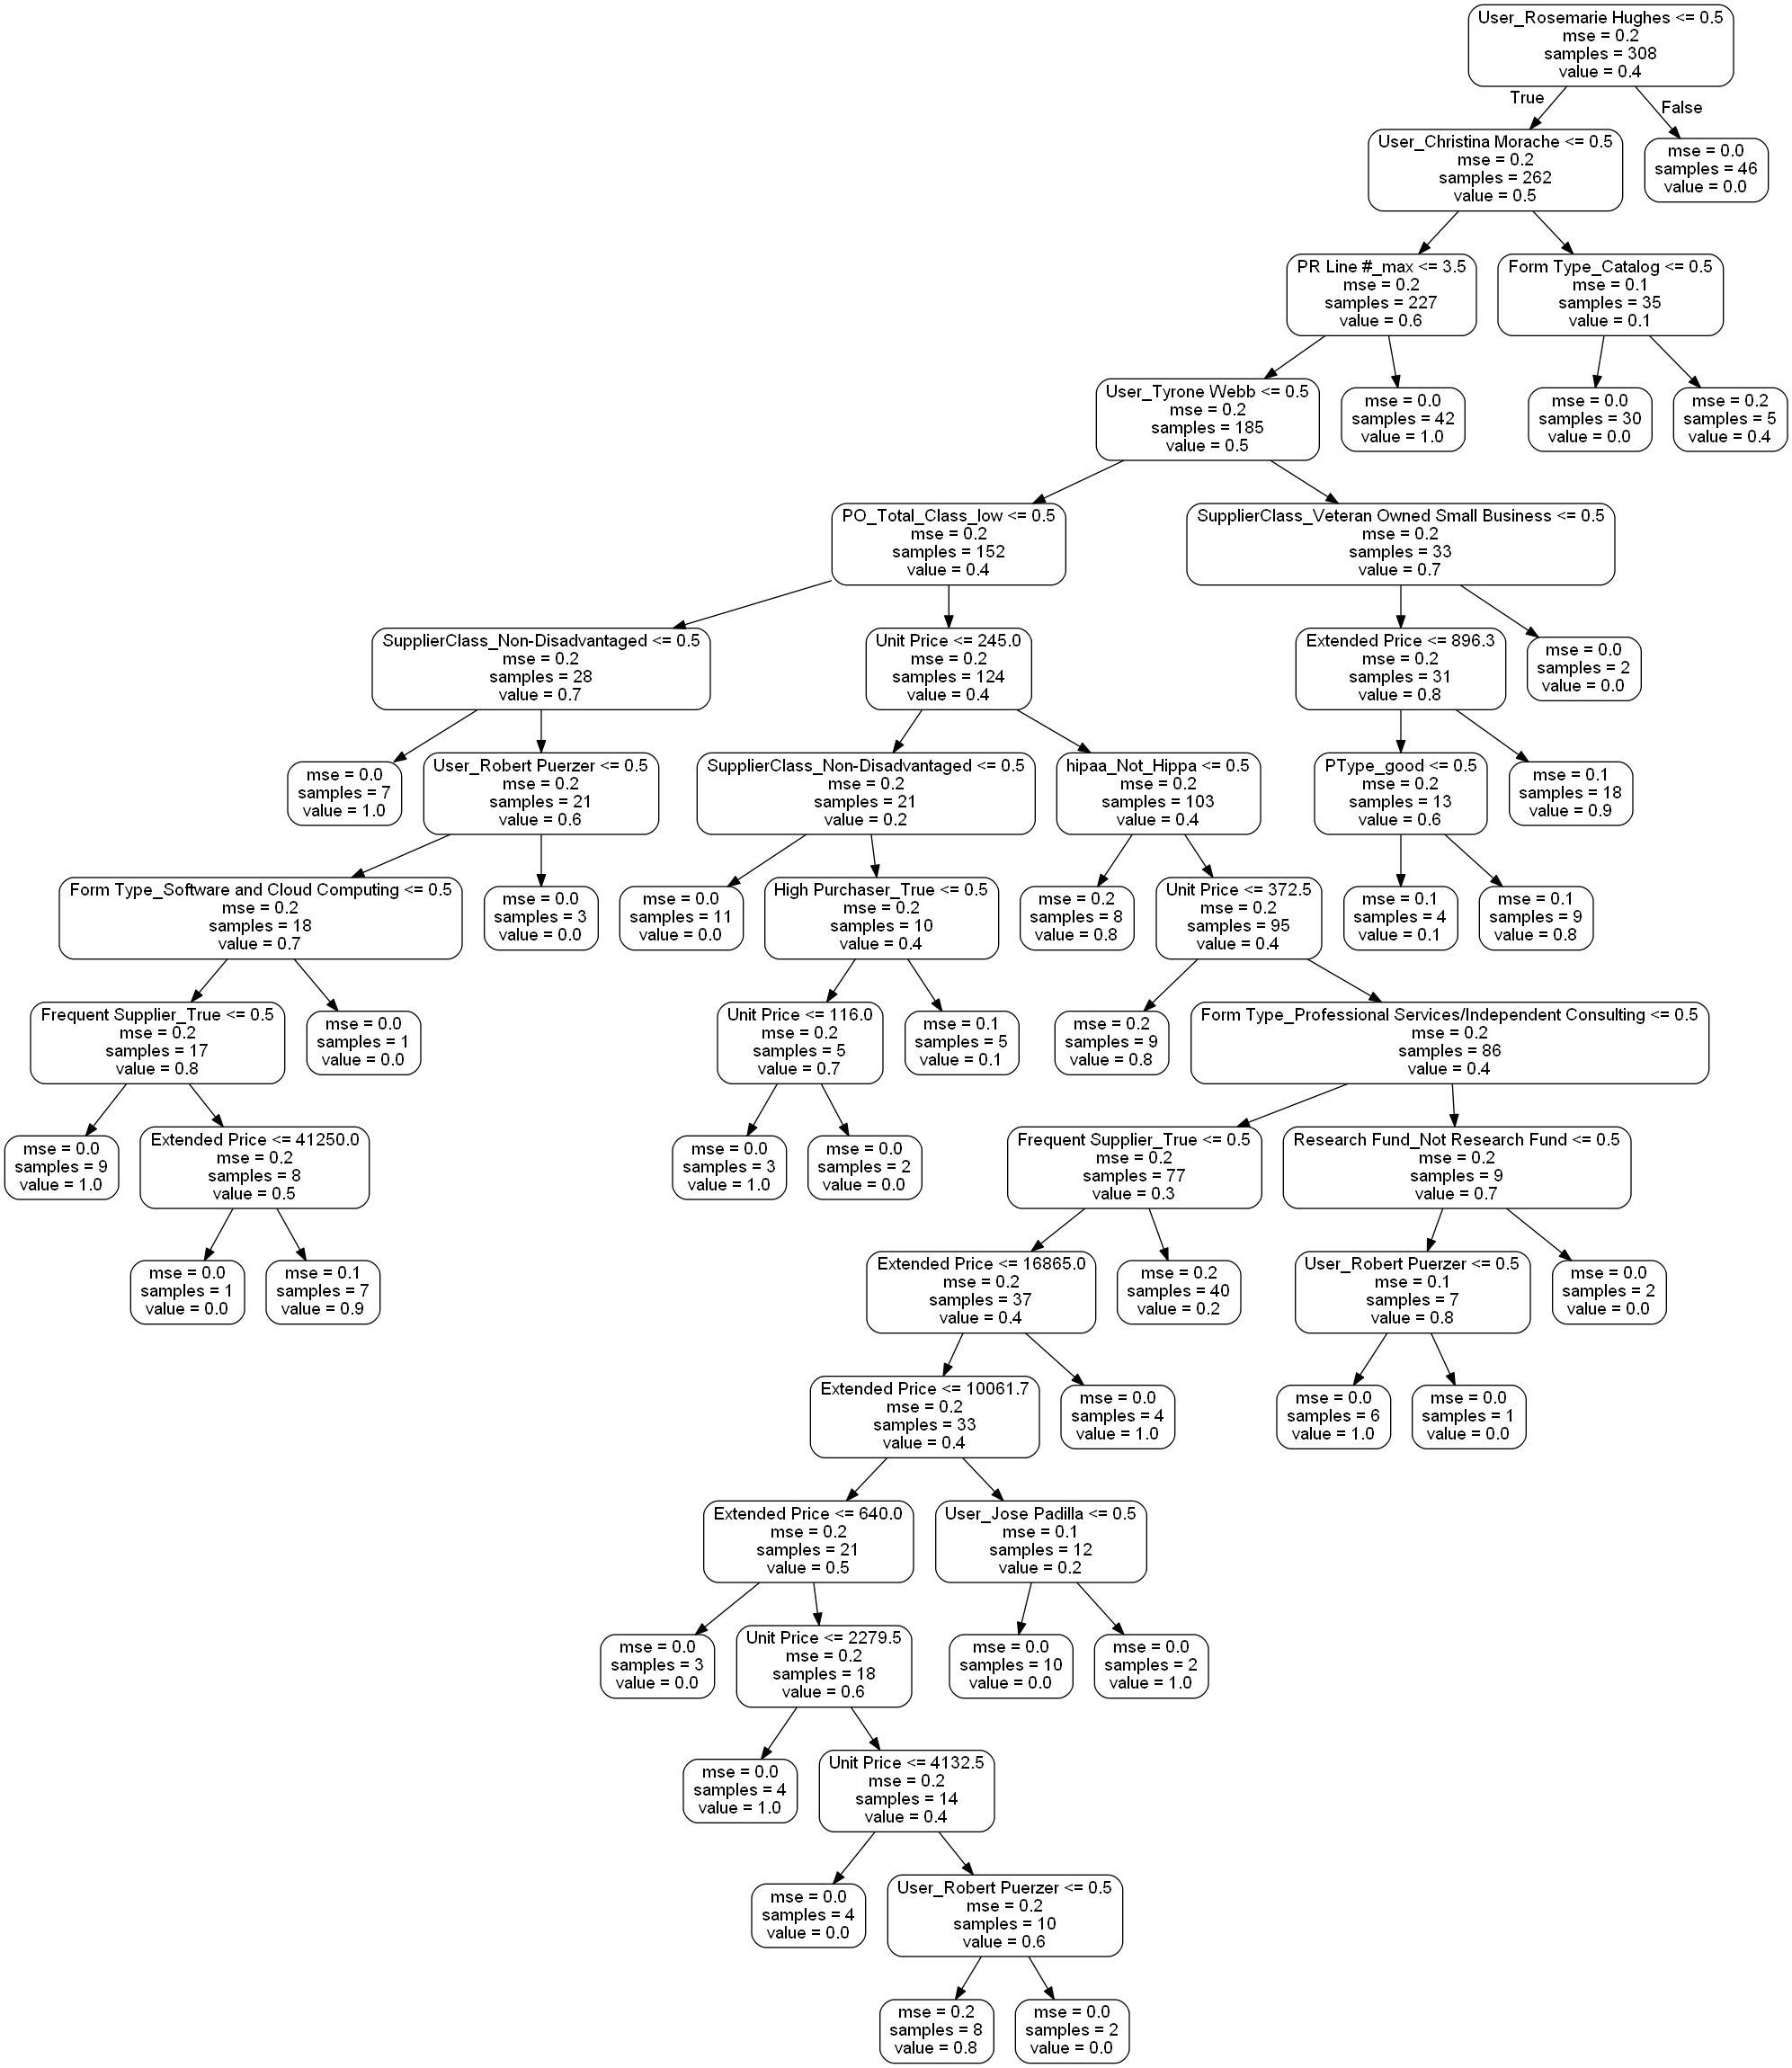

In [49]:
# Pull out one tree from the forest
Rtree = rf.estimators_[11]

# Export the image to a dot file
export_graphviz(Rtree, out_file = 'Rtree.dot',
                feature_names=list(allfeatures),
                rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('Rtree.dot')

# Write graph to a png file
graph.write_png('Rtree.png')

# Output the image
from IPython.display import Image
Image(filename='Rtree.png')

In [50]:
###########################################################################
#MSE Comparison
###########################################################################

In [51]:
#ALL MSE 
print('Seed:',seed)
print('Linear MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('Logistic MSE:', metrics.mean_squared_error(ylog_test, ylog_pred))
print('Decision Tree MSE:', metrics.mean_squared_error(ytree_test, ytree_pred)) 
print('Pruned Decision Tree MSE:', metrics.mean_squared_error(ytree_test, y_predPrunedTree))
print('Random Forest MSE:', metrics.mean_squared_error( yrtree_test, y_predRTree))


Seed: 1
Linear MSE: 2168955.3592926115
Logistic MSE: 0.2396694214876033
Decision Tree MSE: 0.19834710743801653
Pruned Decision Tree MSE: 0.1652892561983471
Random Forest MSE: 0.13830893919199957


In [52]:
###########################################################################
#Cross-Validation
###########################################################################

In [53]:
#K-fold Cross-validation with Linear Regression
reg_accuracy = cross_val_score(regressor, X, y.ravel(), scoring='neg_mean_squared_error', cv = 10)
print("Linear Regression Mean MSE of each test fold:",reg_accuracy.mean()*-1)

Linear Regression Mean MSE of each test fold: 1641991.545119801


In [54]:
#K-fold Cross-validation with Logistic Regression
lr_accuracy = cross_val_score(lr, Xlog, ylog.ravel(), scoring='neg_mean_squared_error', cv = 10)
print("Logistic Regression Mean MSE of each test fold:",lr_accuracy.mean()*-1)

Logistic Regression Mean MSE of each test fold: 0.22526303602852646


In [55]:
#K-fold Cross-validation with Decision Tree
clf_accuracy = cross_val_score(clf, Xtree, ytree.ravel(), scoring='neg_mean_squared_error', cv = 10)
print("Decision Tree Mean MSE of each test fold:",clf_accuracy.mean()*-1)

Decision Tree Mean MSE of each test fold: 0.2519014541076225


In [56]:
#K-fold Cross-validation with Pruned Decision Tree
clfPruned_accuracy = cross_val_score(clf_pruned, Xtree, ytree.ravel(), scoring='neg_mean_squared_error', cv = 10)
print("Pruned Decision Tree Mean MSE of each test fold:",clfPruned_accuracy.mean()*-1)

Pruned Decision Tree Mean MSE of each test fold: 0.22853709363712146


In [57]:
#K-fold Cross-validation with Random Forest
rf_accuracy = cross_val_score(rf, Xrtree, yrtree.ravel(), scoring='neg_mean_squared_error', cv = 10)
print("Random Forest Mean MSE of each test fold:",rf_accuracy.mean()*-1)

Random Forest Mean MSE of each test fold: 0.1508193865700928
